In [ ]:
!pip install numpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def delta_to_ind(delta):
    return int((delta + N) // 2)

def ind_to_s(i):
    return -1+i*2

def normalize(array):
    return array - np.max(array)

def sign_num(x):
    return +1 if x >= 0 else -1

def sign_arr(x):
    x = np.asarray(x)
    return np.where(x >= 0, 1, -1)

def store():
    global q_up_old
    global psi_up_old
    global phi_up_old
    global psi_down_old
    global q_down_old
    global q_singlesite_old
    global weights_old
    global weights_best
    global delta_star_max

    q_up_old = np.copy(q_up)
    psi_up_old = np.copy(psi_up)
    phi_up_old = np.copy(phi_up)
    psi_down_old = np.copy(psi_down)
    q_down_old = np.copy(q_down)
    q_singlesite_old = np.copy(q_singlesite)
    weights_old = np.copy(weights)

    current_delta_star = np.min(np.dot(weights, patterns.T))
    if current_delta_star > delta_star_max:
        delta_star_max = current_delta_star
        weights_best = weights.copy()

# Forward Pass

In [3]:
def update_phi_up():
    global phi_up
    update_xi()
    update_gamma()
    phi_up = np.sum(xi, axis=1) + np.max(gamma, axis=1)

    #NORMALIZE
    phi_up = normalize(phi_up)

def update_xi():
    global xi
    xi[:, :] = np.maximum.accumulate(psi_up[:, ::-1], axis=1)[:, ::-1].T

def update_gamma():
    global gamma
    gamma[:, :] = psi_up.T - xi

# ----------------------

def update_psi_up():
    global psi_up
    global U_minus
    global U_plus
    global I_minus
    global I_plus
    global delta_tilde

    for mu in range(M):
        weights_tilde = sign_arr(q_up.T[mu])
        delta_tilde[mu] = int(np.dot(patterns[mu], weights_tilde))
        psi_up_tilde = np.sum(np.abs(q_up.T[mu]))
        delta_index_tilde = delta_to_ind(delta_tilde[mu])
        psi_up[mu][delta_index_tilde] = psi_up_tilde

        U_plus[mu] = [i for i in range(N) if patterns[mu][i] == sign_num(q_up[i][mu])]
        U_minus[mu] = [i for i in range(N) if patterns[mu][i] != sign_num(q_up[i][mu])]
        I_plus[mu] = sorted(U_plus[mu].copy(),key=lambda i: np.abs(q_up[i][mu]))
        I_minus[mu] = sorted(U_minus[mu].copy(),key=lambda i: np.abs(q_up[i][mu]))

        psi_temp = psi_up_tilde
        delta_index = delta_index_tilde
        for i in I_minus[mu]:
            delta_index += 1
            psi_temp -= np.abs(2*q_up[i][mu])
            psi_up[mu][delta_index] = psi_temp

        psi_temp = psi_up_tilde
        delta_index = delta_index_tilde
        if I_plus[mu] is not None:
            for i in I_plus[mu]:
                delta_index -= 1
                psi_temp -= 2*np.abs(q_up[i][mu])
                psi_up[mu][delta_index] = psi_temp

        #NORMALIZE
        psi_up[mu] = psi_up[mu] - np.sum(np.abs(q_up.T[mu]))

# ----------------------

def update_q_up():
    global q_up
    q_up[:, :] = np.sum(q_down, axis=1, keepdims=True) - q_down

    match SETTING_Q:
        case 1:
            q_up += R * time * q_singlesite_old[:, np.newaxis]


# Backward Pass

In [4]:
def update_phi_down():
    global phi_down
    match SETTING_PHI_DOWN:
        case 0:  # linear spacing
            delta = 1 / N
            for i in range(N+1):
                phi_down[i] = -1 + delta*i
        case 1:  # quadratic spacing
            x = np.linspace(0, 1, N+1)
            x2 = x**2
            x2_norm = (x2 - x2[0]) / (x2[-1] - x2[0]) - 1
            phi_down[:] = x2_norm

        case 2:  # exponential spacing
            x = np.linspace(0, 1, N+1)
            exp_x = np.exp(x)
            exp_x_norm = (exp_x - exp_x[0]) / (exp_x[-1] - exp_x[0]) - 1
            phi_down[:] = exp_x_norm

# ----------------------

def update_psi_down():
    global psi_down
    update_ipsilon()
    for mu in range(M):
        for delta_mu_index in range(N+1):
            max1 = -np.inf
            for delta_star_index in range(delta_mu_index):
                max2 = -np.inf
                for ro in range(M):
                    if ro != mu:
                        max2 = max(max2, gamma[delta_star_index][ro])
                max1 = max(max1, max2 + ipsilon[mu][delta_star_index])
            psi_down[mu][delta_mu_index] = max(max1, ipsilon[mu][delta_mu_index])


    #NORMALIZE
    psi_down = normalize(psi_down)

def update_ipsilon():
    global ipsilon
    for mu in range(M):
        for delta_index in range(N+1):
            ipsilon[mu][delta_index] = sum(xi[delta_index]) - xi[delta_index][mu] + phi_down[delta_index]

# ----------------------

def update_q_down():
    global q_down
    global m_plus
    global M_plus
    global m_minus
    global M_minus
    global delta_star
    global k_star

    for mu in range(M):
        k_tilde = np.array([-1]*N)
        if I_minus[mu] is not None:
            for (k,j) in enumerate(I_minus[mu]):
                k_tilde[j] = k

        for s_index in range(2):
            s = ind_to_s(s_index)
            max1 = -np.inf
            for delta_under in POSSIBLE_DELTA_UNDERLINED:
                index1 = delta_to_ind(delta_under + 1)
                index2 = delta_to_ind(delta_under + s)
                max1 = max(max1, psi_up[mu][index1] + psi_down[mu][index2])
            m_plus[mu][s_index] = max1
        M_plus[mu] = (m_plus[mu][1] - m_plus[mu][0]) / 2

        for s_index in range(2):
            s = ind_to_s(s_index)
            max1 = -np.inf
            argmax1 = -N+1
            for delta_under in POSSIBLE_DELTA_UNDERLINED:
                index1 = delta_to_ind(delta_under - 1)
                index2 = delta_to_ind(delta_under + s)
                if max1 < psi_up[mu][index1] + psi_down[mu][index2]:
                    max1 = psi_up[mu][index1] + psi_down[mu][index2]
                    argmax1 = delta_under
            delta_star[mu][s_index] = argmax1

            index1 = delta_to_ind(delta_star[mu][s_index] - 1)
            index2 = delta_to_ind(delta_star[mu][s_index] + s)
            m_minus[mu][s_index] = max1
            k_star[mu][s_index] = (delta_star[mu][s_index] - delta_tilde[mu] - 1) // 2
        M_minus[mu] = (m_minus[mu][1] - m_minus[mu][0]) / 2

        for j in U_plus[mu]:
            q_down[j][mu] = patterns[mu][j] * M_plus[mu]
        for j in U_minus[mu]:
            if k_tilde[j] > max(k_star[mu]):
                q_down[j][mu] = patterns[mu][j] * M_minus[mu]
            else:
                m_hat = np.zeros(2)
                for s_index in range(2):
                    s = ind_to_s(s_index)

                    index1 = delta_to_ind(delta_tilde[mu])
                    index2 = delta_to_ind(delta_tilde[mu] + 1 + s)
                    max1 = psi_up[mu][index1] + psi_down[mu][index2]

                    for k in range(1, int(k_star[mu][s_index])+1):
                        index1 = delta_to_ind(delta_tilde[mu] + 2*k)
                        index2 = delta_to_ind(delta_tilde[mu] + 2*k + 1 + s)
                        temp_sum = psi_up[mu][index1] + psi_down[mu][index2]
                        if k > k_tilde[j]:
                            temp_sum -= 2*(np.abs(q_up[I_minus[mu][k]][mu]) - np.abs(q_up[j][mu]))
                        max1 = max(max1, temp_sum)
                    m_hat[s_index] = max1 - np.abs(q_up[j][mu])

                M_hat = (m_hat[1] - m_hat[0]) / 2
                q_down[j][mu] = patterns[mu][j] * M_hat

# Single-site Quantities and Weights Updates

In [5]:
def update_singlesite():
    global q_singlesite
    q_singlesite[:] = np.sum(q_down, axis=1)
    match SETTING_Q:
        case 1:
            q_singlesite += R * time * q_singlesite_old

def update_weights():
    global weights
    update_singlesite()
    weights[:] = sign_arr(q_singlesite)

# Convergence Iterations

In [6]:
def check_convergence():
    check_weights()
    # check_differences()

    if COUNTERS[0] >= WEIGHTS_MAX_ITERATIONS:
        return True

    return False

def check_weights():
    global COUNTERS
    if np.array_equal(weights, weights_old):
        COUNTERS[0] += 1
    else:
        COUNTERS[0] = 0

def check_differences():
    global COUNTERS
    differences = []
    differences.append(np.max(np.abs(q_up - q_up_old)))
    differences.append(np.max(np.abs(psi_up - psi_up_old)))
    differences.append(np.max(np.abs(phi_up - phi_up_old)))
    differences.append(np.max(np.abs(psi_down - psi_down_old)))
    differences.append(np.max(np.abs(q_down - q_down_old)))

    if np.max(differences) < THRESHOLD:
        COUNTERS[1] += 1
    else:
        COUNTERS[1] = 0


In [7]:
def forward_pass():
    update_q_up()
    update_psi_up()
    update_phi_up()

def backward_pass():
    update_phi_down()
    update_psi_down()
    update_q_down()

def converge():
    global delta_star_convergence
    global convergence_iteration
    global time

    convergence = False
    for i in range(ITERATIONS):
        forward_pass()
        backward_pass()
        update_weights()

        if (i%500==0):
          print("ITERATION: ", i, "weights: ", weights)

        if check_convergence():
            convergence = True
            convergence_iteration = i
            delta_star_convergence = min(np.dot(weights, patterns.T))
            break

        store()
        time += 1

    return convergence

# Simulations

In [ ]:
for i in range(100):
    seed = 5000+i*5
    np.random.seed(seed)

    N = 101    # dimension of patterns
    M = 30    # number of patterns M = alpha * N
    THRESHOLD = 1e-4
    ITERATIONS = 10000
    WEIGHTS_MAX_ITERATIONS = 10
    MESSAGES_MAX_ITERATIONS = 10
    POSSIBLE_DELTA_UNDERLINED = [-N+1+i*2 for i in range(N)]
    SETTING_PHI_DOWN = 0   # 0 linear, 1 squared, 2 exponential
    SETTING_Q = 1  # 0 non-forced, 1 forced
    R = 0.01
    COUNTERS = [0,0]
    convergence_iteration = ITERATIONS
    time = 0

    # data structures for weights and patterns
    weights = np.random.choice([-1, 1], size=N)
    patterns = np.random.choice([-1, 1], size=(M, N))

    # data structures for messages
    q_up = np.zeros((N,M))
    psi_up = np.zeros((M,N+1))
    phi_up = np.zeros(N+1)
    phi_down = np.zeros(N+1)
    psi_down = np.zeros((M,N+1))
    q_down = np.zeros((N,M))

    # single-site quantities
    q_singlesite = np.zeros(N)

    # data structures for auxiliary messages
    xi = np.zeros((N+1, M))
    gamma = np.zeros((N+1, M))
    ipsilon = np.zeros((M,N+1))

    # data structures for auxiliary quantities
    delta_tilde = np.zeros(M)
    U_plus = [[] for _ in range(M)]
    U_minus = [[] for _ in range(M)]
    I_plus = [[] for _ in range(M)]
    I_minus = [[] for _ in range(M)]
    m_plus = np.zeros((M, 2))
    M_plus = np.zeros(M)
    m_minus = np.zeros((M,2))
    M_minus = np.zeros(M)
    delta_star = np.zeros((M,2))
    k_star = np.zeros((M,2))

    # data structures to store messages and weights
    q_up_old = np.zeros((N,M))
    psi_up_old = np.zeros((M,N+1))
    phi_up_old = np.zeros(N+1)
    phi_down_old = np.zeros(N+1)
    psi_down_old = np.zeros((M,N+1))
    q_down_old = np.zeros((N,M))

    q_singlesite_old = np.zeros(N)

    weights_old = np.zeros(N)
    weights_best = weights.copy()
    delta_star_max = -N
    delta_star_convergence = -N

    # RUN ALGORITHM
    converged = False
    if converge():
            converged = True

    with open("results_forced_linear.txt", 'a') as f:
        f.write(f"\n{N}  {M}  {M/N}  {ITERATIONS}  {converged}  {convergence_iteration}  {delta_star_max}  {delta_star_convergence}  {seed}")
        f.flush()


ITERATION:  0 weights:  [ 1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1
 -1 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1
  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1 -1 -1 -1  1
  1  1  1 -1  1]
ITERATION:  0 weights:  [ 1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1
  1  1  1 -1  1 -1 -1  1  1  1  1  1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1  1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1
  1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
ITERATION:  0 weights:  [-1  1  1  1  1  1  1  1 -1 -1  1 -1  1 -1  1  1  1 -1  1 -1  1  1 -1  1
  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1
  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1  1  1 -1 -1  1
 -1 -1 -1 -1  1 -1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1
 -1 -1 -1  1 -1]
I

# Histograms for Simulations

### Non Forced 

C:\Users\busat\AppData\Local\Temp\ipykernel_11892\1771097101.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, skiprows=1)



Summary Statistics for Delta_max:
count    103.000000
mean      -1.796117
std        7.070179
min      -17.000000
25%       -7.000000
50%       -1.000000
75%        5.000000
max        9.000000
Name: Delta_max, dtype: float64


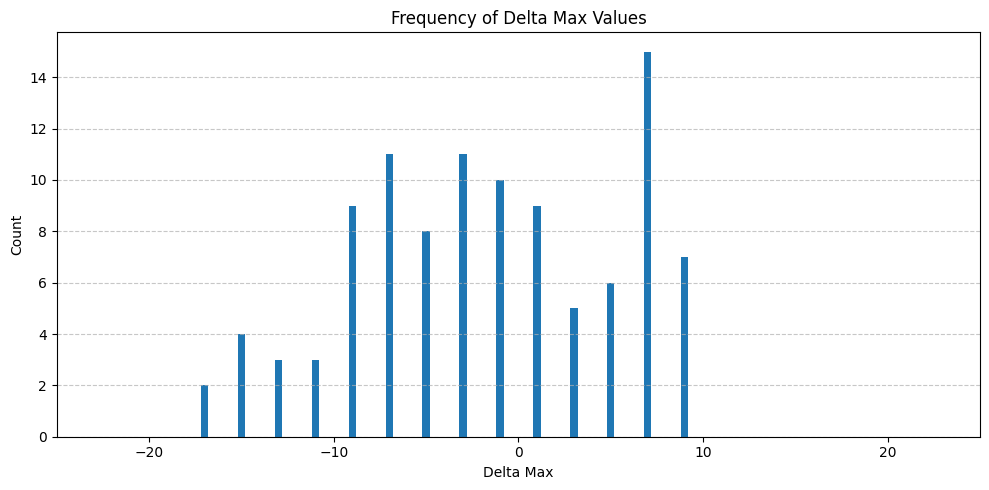

In [9]:
filename = "results_nonforced.txt"
df = pd.read_csv(filename, delim_whitespace=True, skiprows=1)

print("\nSummary Statistics for Delta_max:")
print(df['Delta_max'].describe())

delta_counts = df['Delta_max'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(delta_counts.index, delta_counts.values, width=0.4, align='center')
plt.title('Frequency of Delta Max Values')
plt.xlabel('Delta Max')
plt.ylabel('Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xlim(-25, 25)
plt.tight_layout()
plt.show()

### Forced

C:\Users\busat\AppData\Local\Temp\ipykernel_11892\3941172291.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, skiprows=1)



--- M=30, r=0.01 ---
Delta_max stats:
count    32.000000
mean     -3.687500
std       5.738593
min     -13.000000
25%      -7.000000
50%      -5.000000
75%      -1.000000
max       9.000000
Name: Delta_max, dtype: float64
Delta_convergence stats:
count    32.000000
mean    -11.562500
std       8.669329
min     -23.000000
25%     -17.000000
50%     -14.000000
75%      -7.000000
max       9.000000
Name: Delta_convergence, dtype: float64


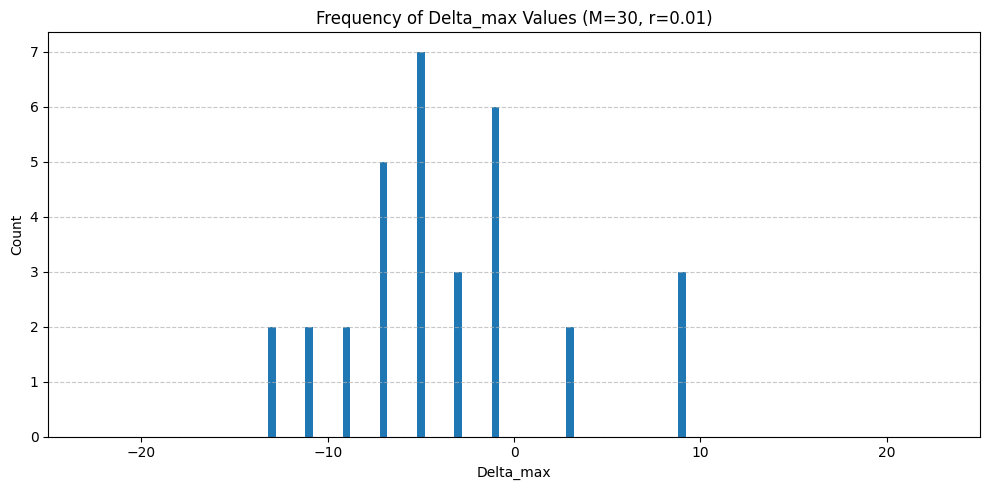

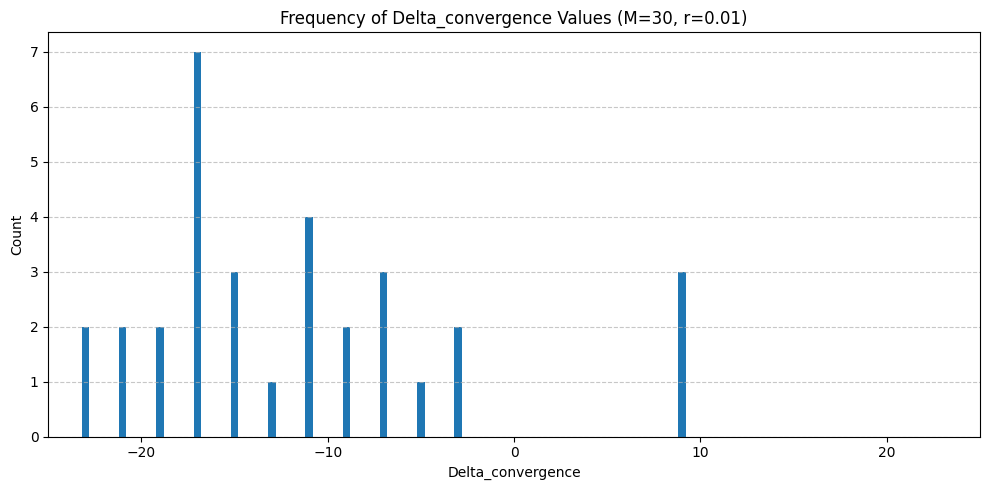


--- M=30, r=0.001 ---
Delta_max stats:
count    81.000000
mean     -2.358025
std       3.792455
min      -9.000000
25%      -5.000000
50%      -3.000000
75%      -1.000000
max       9.000000
Name: Delta_max, dtype: float64
Delta_convergence stats:
count    81.000000
mean     -5.370370
std       4.859127
min     -17.000000
25%      -9.000000
50%      -5.000000
75%      -3.000000
max       9.000000
Name: Delta_convergence, dtype: float64


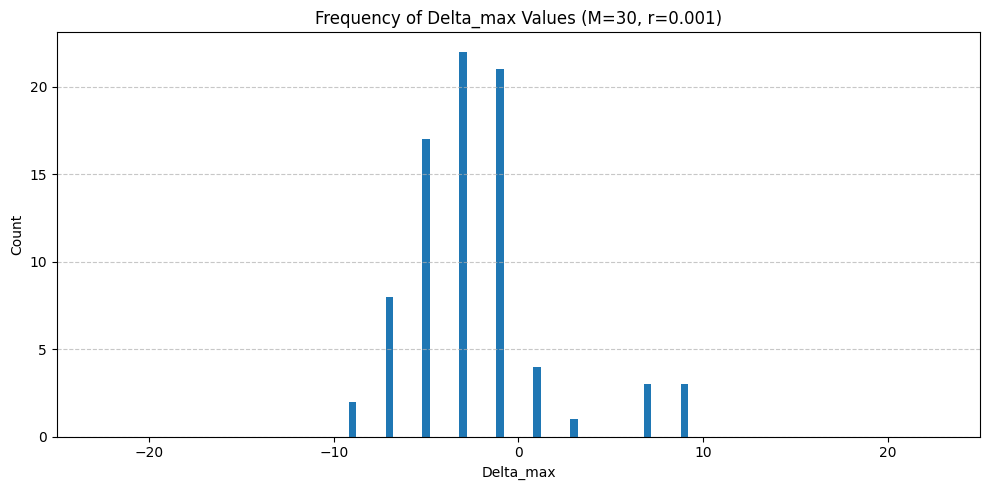

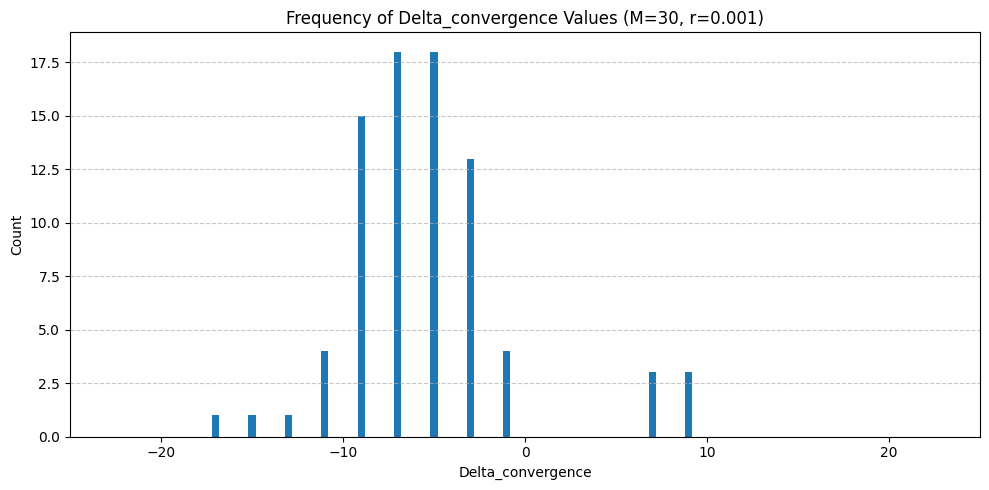


--- M=40 ---
Delta_max stats:
count    19.000000
mean     -3.947368
std       3.290959
min      -7.000000
25%      -7.000000
50%      -5.000000
75%      -3.000000
max       5.000000
Name: Delta_max, dtype: float64
Delta_convergence stats:
count    19.000000
mean     -7.526316
std       4.611199
min     -17.000000
25%     -10.000000
50%      -9.000000
75%      -6.000000
max       5.000000
Name: Delta_convergence, dtype: float64


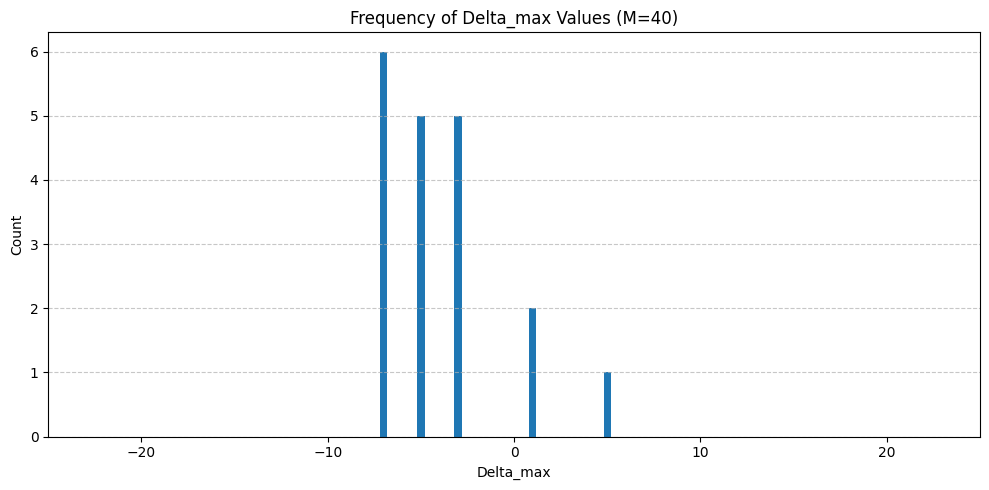

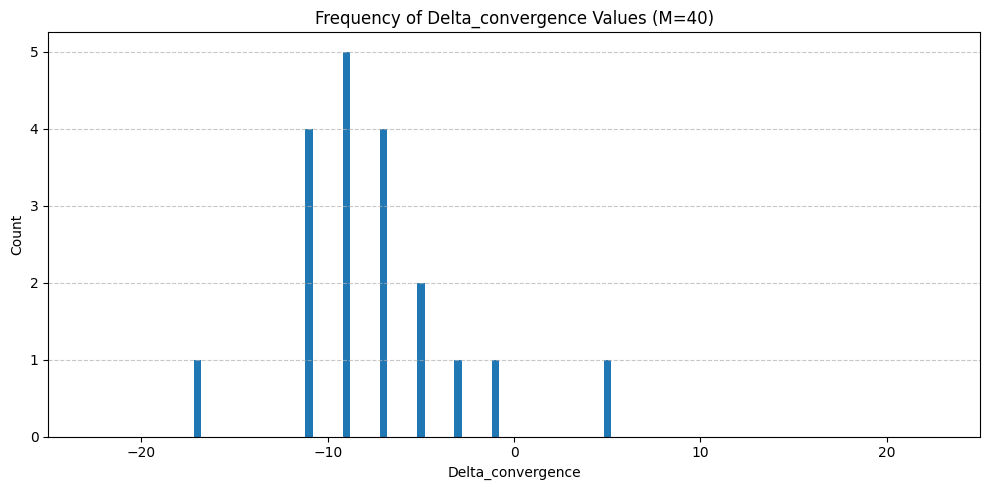


--- M=20 ---
Delta_max stats:
count    41.000000
mean      3.439024
std       4.393454
min      -3.000000
25%       1.000000
50%       3.000000
75%       5.000000
max      13.000000
Name: Delta_max, dtype: float64
Delta_convergence stats:
count    41.000000
mean     -0.073171
std       5.746261
min      -9.000000
25%      -3.000000
50%      -1.000000
75%       1.000000
max      13.000000
Name: Delta_convergence, dtype: float64


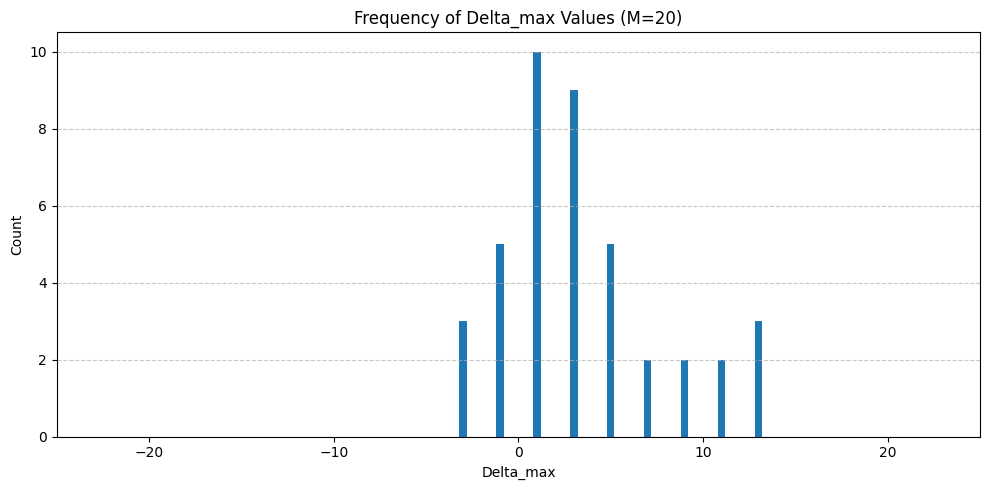

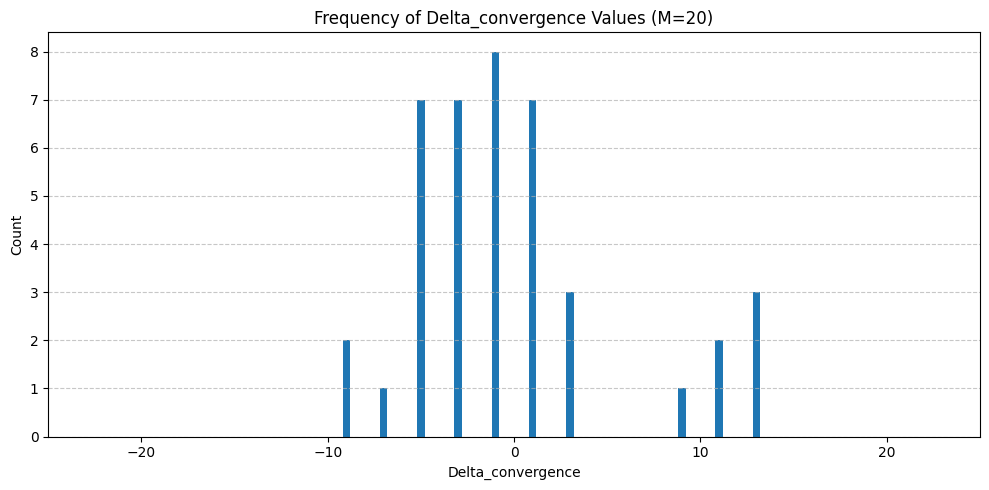

In [11]:
filename = "results_forced.txt"
df = pd.read_csv(filename, delim_whitespace=True, skiprows=1)

categories = {
    "M=30, r=0.01": df[(df["N"] == 101) & (df["M"] == 30) & (df["Random_seed"] < 1000)],
    "M=30, r=0.001": df[(df["N"] == 101) & (df["M"] == 30) & (df["Random_seed"] >= 1000)],
    "M=40": df[(df["N"] == 101) & (df["M"] == 40)],
    "M=20": df[(df["N"] == 101) & (df["M"] == 20)]
}

def plot_bar(data, column, title_suffix):
    value_counts = data[column].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    plt.bar(value_counts.index, value_counts.values, width=0.4, align='center')
    plt.title(f'Frequency of {column} Values ({title_suffix})')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xlim(-25, 25)
    plt.tight_layout()
    plt.show()

for label, subset in categories.items():
    print(f"\n--- {label} ---")
    print("Delta_max stats:")
    print(subset["Delta_max"].describe())
    print("Delta_convergence stats:")
    print(subset["Delta_convergence"].describe())

    plot_bar(subset, "Delta_max", label)
    plot_bar(subset, "Delta_convergence", label)

# TO DO:
1. SIMULATIONS:

Forced Convergence:
- Linear Phi (Alpha = 0.3, 0.4, 0.5, 0.6, 0.7)
- Squared Phi (Alpha = 0.3, 0.4, 0.5, 0.6, 0.7)
- Exponential Phi (Alpha = 0.3, 0.4, 0.5, 0.6, 0.7, 0.75 R=0.001)

Non Forced Convergence:
- Linear Phi (Alpha = 0.3)
- Squared Phi (Alpha = 0.3)
- Exponential Phi (Alpha = 0.3) 

2. GRAPHS AND HISTOGRAMS